# FinRL library installlation and environment prapare
# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime
from finrl.config import config
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.environment import EnvSetup
from finrl.env.EnvMultipleStock_train import StockEnvTrain
from finrl.env.EnvMultipleStock_trade import StockEnvTrade
from finrl.env.env_portfolio import StockPortfolioEnv
from finrl.env.env_stocktrading import StockTradingEnv
from finrl.model.models import DRLAgent
from finrl.trade.backtest import backtest_stats, get_baseline, backtest_plot


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/Users/chloewenqi/anaconda3/lib/python3.7/site-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."
/Users/chloewenqi/anaconda3/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [2]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

# Preprocess Data

In [3]:
D1 = pd.read_pickle('./Dataset_B02_10mins_OHLCV.pkl')
D2 = pd.read_pickle('./Dataset_B02_10mins.pkl')

In [4]:
Data1=D1
Data1.insert(loc=5,column='tic',value='HSBC')
Data1['date'] = Data1.index
Data1 = Data1.rename(columns={'Close':'close'})

In [5]:
Data1.head()

,Open,High,Low,close,Volume,tic,date
0,253,275,253,262,316346,HSBC,0
1,268,272,254,263,310547,HSBC,1
2,259,272,252,262,323198,HSBC,2
3,262,272,250,256,317700,HSBC,3
4,259,271,251,252,318941,HSBC,4


FinRL uses a class FeatureEngineer to preprocess the data
Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc.

FinRL uses stockstats to calcualte technical indicators such as Moving Average Convergence Divergence (MACD), Relative Strength Index (RSI), Average Directional Index (ADX), Commodity Channel Index (CCI) and other various indicators and stats.

stockstats: supplies a wrapper StockDataFrame based on the pandas.DataFrame with inline stock statistics/indicators support.



In [6]:
#the stockstats technical indicator column
tech_indicator_list=config.TECHNICAL_INDICATORS_LIST
print(tech_indicator_list)

['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']


In [7]:
#Perform Feature Engineering and add technical indicators
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = tech_indicator_list,
                    use_turbulence=False,
                    user_defined_feature = False)

data_df = fe.preprocess_data(Data1)

Successfully added technical indicators


In [8]:
data_df.head()

,Open,High,Low,close,Volume,tic,date,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,253,275,253,262,316346,HSBC,0,0.000000,263.914214,261.085786,100.000000,-66.666667,100.0,262.000000,262.000000
1,268,272,254,263,310547,HSBC,1,0.022436,263.914214,261.085786,100.000000,-66.666667,100.0,262.500000,262.500000
2,259,272,252,262,323198,HSBC,2,-0.002422,263.488034,261.178633,49.152542,-100.000000,100.0,262.333333,262.333333
3,262,272,250,256,317700,HSBC,3,-0.230296,267.153124,254.346876,11.826747,-133.333333,100.0,260.750000,260.750000
4,259,271,251,252,318941,HSBC,4,-0.508441,268.591663,249.408337,7.761784,-105.855856,100.0,259.000000,259.000000


# Build Environment

Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a Markov Decision Process (MDP) problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Train & Trade data split

In [9]:
# data split
train = data_split(data_df, start = 0, end = 1020)
trade = data_split(data_df, start = 1020, end = 2040)

## Data normalization

In [10]:
# data normalization, this part is optional, have little impact
train_ = train
trade_ = trade
feaures_list = list(train_.columns)
feaures_list.remove('date')
feaures_list.remove('tic')
feaures_list.remove('close')
print(feaures_list)
from sklearn import preprocessing
data_normaliser = preprocessing.StandardScaler()
train_[feaures_list] = data_normaliser.fit_transform(train_[feaures_list])
trade_[feaures_list] = data_normaliser.transform(trade_[feaures_list])

['Open', 'High', 'Low', 'Volume', 'macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']


In [11]:
train_.head()

,Open,High,Low,close,Volume,tic,date,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,1.184538,1.626066,1.498076,262,0.434929,HSBC,0,0.156066,1.153096,1.895972,9.383233,-0.403502,3.071683,1.497940,1.507665
1,1.719673,1.518908,1.533947,263,0.234707,HSBC,1,0.163599,1.153096,1.895972,9.383233,-0.403502,3.071683,1.516186,1.526465
2,1.398592,1.518908,1.462206,262,0.671508,HSBC,2,0.155253,1.138307,1.899455,0.038910,-0.704967,3.071683,1.510104,1.520198
3,1.505619,1.518908,1.390465,256,0.481679,HSBC,3,0.078744,1.265488,1.643204,-6.820514,-1.006431,3.071683,1.452325,1.460663
4,1.398592,1.483189,1.426336,252,0.524527,HSBC,4,-0.014644,1.315406,1.457965,-7.567539,-0.757927,3.071683,1.388464,1.394861


## Initialize Environment
- stock dimension: the number of unique stock tickers we use
- hmax: the maximum amount of shares to buy or sell
- initial amount: the amount of money we use to trade in the begining
- transaction cost percentage: a per share rate for every share trade
- tech_indicator_list: a list of technical indicator names (modified from config.py)

In [12]:
# target stock
print(len(train.tic.unique()))
timesteps = int(100000)

1


In [13]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 1, State Space: 11


In [14]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 100000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4    
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

```
class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}
```

In [15]:
#Creates a simple vectorized wrapper for multiple environments, 
#calling each environment in sequence on the current Python process.
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [16]:
#A2C Model
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=timesteps)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device
Logging to tensorboard_log/a2c/a2c_26
------------------------------------
| time/                 |          |
|    fps                | 530      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.42    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 99       |
|    policy_loss        | 0.0863   |
|    std                | 1        |
|    value_loss         | 0.00437  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 541      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -1.42    |
|    explained_variance | 0        

------------------------------------
| time/                 |          |
|    fps                | 558      |
|    iterations         | 1400     |
|    time_elapsed       | 12       |
|    total_timesteps    | 7000     |
| train/                |          |
|    entropy_loss       | -1.46    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 1399     |
|    policy_loss        | 0.0438   |
|    std                | 1.04     |
|    value_loss         | 0.00164  |
------------------------------------
-------------------------------------
| environment/          |           |
|    portfolio_value    | 9.71e+04  |
|    total_cost         | 5.39e+03  |
|    total_reward       | -2.92e+03 |
|    total_reward_pct   | -2.92     |
|    total_trades       | 495       |
| time/                 |           |
|    fps                | 559       |
|    iterations         | 1500      |
|    time_elapsed       | 13        |
|    total_timesteps    | 7

------------------------------------
| time/                 |          |
|    fps                | 574      |
|    iterations         | 2600     |
|    time_elapsed       | 22       |
|    total_timesteps    | 13000    |
| train/                |          |
|    entropy_loss       | -1.52    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 2599     |
|    policy_loss        | 0.00682  |
|    std                | 1.1      |
|    value_loss         | 2.91e-05 |
------------------------------------
-------------------------------------
| environment/          |           |
|    portfolio_value    | 9.81e+04  |
|    total_cost         | 784       |
|    total_reward       | -1.91e+03 |
|    total_reward_pct   | -1.91     |
|    total_trades       | 87        |
| time/                 |           |
|    fps                | 575       |
|    iterations         | 2700      |
|    time_elapsed       | 23        |
|    total_timesteps    | 1

day: 1019, episode: 20
begin_total_asset: 100000.00
end_total_asset: 101431.69
total_reward: 1431.69
total_cost: 2342.31
total_trades: 219
Sharpe: 0.202
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.01e+05 |
|    total_cost         | 2.34e+03 |
|    total_reward       | 1.43e+03 |
|    total_reward_pct   | 1.43     |
|    total_trades       | 219      |
| time/                 |          |
|    fps                | 584      |
|    iterations         | 3900     |
|    time_elapsed       | 33       |
|    total_timesteps    | 19500    |
| train/                |          |
|    entropy_loss       | -1.61    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 3899     |
|    policy_loss        | 0.00515  |
|    std                | 1.21     |
|    value_loss         | 1.64e-05 |
------------------------------------
-------------------------------------
| time/                 |       

-------------------------------------
| environment/          |           |
|    portfolio_value    | 9.64e+04  |
|    total_cost         | 3.09e+03  |
|    total_reward       | -3.59e+03 |
|    total_reward_pct   | -3.59     |
|    total_trades       | 254       |
| time/                 |           |
|    fps                | 583       |
|    iterations         | 5100      |
|    time_elapsed       | 43        |
|    total_timesteps    | 25500     |
| train/                |           |
|    entropy_loss       | -1.67     |
|    explained_variance | 0         |
|    learning_rate      | 0.0002    |
|    n_updates          | 5099      |
|    policy_loss        | -0.00169  |
|    std                | 1.29      |
|    value_loss         | 1.39e-06  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 583      |
|    iterations         | 5200     |
|    time_elapsed       | 44       |
|    total_timest

-------------------------------------
| time/                 |           |
|    fps                | 583       |
|    iterations         | 6300      |
|    time_elapsed       | 53        |
|    total_timesteps    | 31500     |
| train/                |           |
|    entropy_loss       | -1.74     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 6299      |
|    policy_loss        | -0.000457 |
|    std                | 1.38      |
|    value_loss         | 1.02e-07  |
-------------------------------------
-------------------------------------
| environment/          |           |
|    portfolio_value    | 9.85e+04  |
|    total_cost         | 2.18e+03  |
|    total_reward       | -1.54e+03 |
|    total_reward_pct   | -1.54     |
|    total_trades       | 202       |
| time/                 |           |
|    fps                | 583       |
|    iterations         | 6400      |
|    time_elapsed       | 54        |
|    total_t

-------------------------------------
| environment/          |           |
|    portfolio_value    | 9.75e+04  |
|    total_cost         | 1.73e+03  |
|    total_reward       | -2.51e+03 |
|    total_reward_pct   | -2.51     |
|    total_trades       | 146       |
| time/                 |           |
|    fps                | 587       |
|    iterations         | 7600      |
|    time_elapsed       | 64        |
|    total_timesteps    | 38000     |
| train/                |           |
|    entropy_loss       | -1.8      |
|    explained_variance | 0         |
|    learning_rate      | 0.0002    |
|    n_updates          | 7599      |
|    policy_loss        | -0.00621  |
|    std                | 1.46      |
|    value_loss         | 6.47e-06  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 587      |
|    iterations         | 7700     |
|    time_elapsed       | 65       |
|    total_timest

-------------------------------------
| environment/          |           |
|    portfolio_value    | 9.89e+04  |
|    total_cost         | 349       |
|    total_reward       | -1.13e+03 |
|    total_reward_pct   | -1.13     |
|    total_trades       | 21        |
| time/                 |           |
|    fps                | 589       |
|    iterations         | 8800      |
|    time_elapsed       | 74        |
|    total_timesteps    | 44000     |
| train/                |           |
|    entropy_loss       | -1.84     |
|    explained_variance | 0         |
|    learning_rate      | 0.0002    |
|    n_updates          | 8799      |
|    policy_loss        | -0.00886  |
|    std                | 1.53      |
|    value_loss         | 1.74e-05  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 589      |
|    iterations         | 8900     |
|    time_elapsed       | 75       |
|    total_timest

------------------------------------
| time/                 |          |
|    fps                | 592      |
|    iterations         | 10100    |
|    time_elapsed       | 85       |
|    total_timesteps    | 50500    |
| train/                |          |
|    entropy_loss       | -1.94    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 10099    |
|    policy_loss        | 0.00155  |
|    std                | 1.68     |
|    value_loss         | 1.18e-06 |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.01e+05 |
|    total_cost         | 643      |
|    total_reward       | 936      |
|    total_reward_pct   | 0.936    |
|    total_trades       | 53       |
| time/                 |          |
|    fps                | 592      |
|    iterations         | 10200    |
|    time_elapsed       | 86       |
|    total_timesteps    | 51000    |
|

-------------------------------------
| time/                 |           |
|    fps                | 593       |
|    iterations         | 11400     |
|    time_elapsed       | 95        |
|    total_timesteps    | 57000     |
| train/                |           |
|    entropy_loss       | -2.05     |
|    explained_variance | 0         |
|    learning_rate      | 0.0002    |
|    n_updates          | 11399     |
|    policy_loss        | -0.000954 |
|    std                | 1.87      |
|    value_loss         | 1.88e-07  |
-------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.04e+05 |
|    total_cost         | 654      |
|    total_reward       | 4.29e+03 |
|    total_reward_pct   | 4.29     |
|    total_trades       | 51       |
| time/                 |          |
|    fps                | 593      |
|    iterations         | 11500    |
|    time_elapsed       | 96       |
|    total_timesteps   

-------------------------------------
| time/                 |           |
|    fps                | 593       |
|    iterations         | 12600     |
|    time_elapsed       | 106       |
|    total_timesteps    | 63000     |
| train/                |           |
|    entropy_loss       | -2.12     |
|    explained_variance | 0         |
|    learning_rate      | 0.0002    |
|    n_updates          | 12599     |
|    policy_loss        | -0.000349 |
|    std                | 2.02      |
|    value_loss         | 3.32e-08  |
-------------------------------------
-------------------------------------
| environment/          |           |
|    portfolio_value    | 9.29e+04  |
|    total_cost         | 1.4e+03   |
|    total_reward       | -7.13e+03 |
|    total_reward_pct   | -7.13     |
|    total_trades       | 103       |
| time/                 |           |
|    fps                | 594       |
|    iterations         | 12700     |
|    time_elapsed       | 106       |
|    total_t

-------------------------------------
| environment/          |           |
|    portfolio_value    | 9.77e+04  |
|    total_cost         | 1.55e+03  |
|    total_reward       | -2.33e+03 |
|    total_reward_pct   | -2.33     |
|    total_trades       | 106       |
| time/                 |           |
|    fps                | 594       |
|    iterations         | 13900     |
|    time_elapsed       | 116       |
|    total_timesteps    | 69500     |
| train/                |           |
|    entropy_loss       | -2.19     |
|    explained_variance | 0         |
|    learning_rate      | 0.0002    |
|    n_updates          | 13899     |
|    policy_loss        | -0.00362  |
|    std                | 2.17      |
|    value_loss         | 4.29e-06  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 594      |
|    iterations         | 14000    |
|    time_elapsed       | 117      |
|    total_timest

-------------------------------------
| environment/          |           |
|    portfolio_value    | 9.82e+04  |
|    total_cost         | 1.22e+03  |
|    total_reward       | -1.79e+03 |
|    total_reward_pct   | -1.79     |
|    total_trades       | 85        |
| time/                 |           |
|    fps                | 594       |
|    iterations         | 15100     |
|    time_elapsed       | 126       |
|    total_timesteps    | 75500     |
| train/                |           |
|    entropy_loss       | -2.25     |
|    explained_variance | 0         |
|    learning_rate      | 0.0002    |
|    n_updates          | 15099     |
|    policy_loss        | 5.64e-05  |
|    std                | 2.29      |
|    value_loss         | 1.1e-09   |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 594      |
|    iterations         | 15200    |
|    time_elapsed       | 127      |
|    total_timest

------------------------------------
| time/                 |          |
|    fps                | 594      |
|    iterations         | 16300    |
|    time_elapsed       | 137      |
|    total_timesteps    | 81500    |
| train/                |          |
|    entropy_loss       | -2.31    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 16299    |
|    policy_loss        | 0.000544 |
|    std                | 2.43     |
|    value_loss         | 8.85e-08 |
------------------------------------
-------------------------------------
| environment/          |           |
|    portfolio_value    | 9.76e+04  |
|    total_cost         | 1.66e+03  |
|    total_reward       | -2.36e+03 |
|    total_reward_pct   | -2.36     |
|    total_trades       | 115       |
| time/                 |           |
|    fps                | 594       |
|    iterations         | 16400     |
|    time_elapsed       | 137       |
|    total_timesteps    | 8

-------------------------------------
| environment/          |           |
|    portfolio_value    | 9.88e+04  |
|    total_cost         | 750       |
|    total_reward       | -1.25e+03 |
|    total_reward_pct   | -1.25     |
|    total_trades       | 57        |
| time/                 |           |
|    fps                | 594       |
|    iterations         | 17600     |
|    time_elapsed       | 148       |
|    total_timesteps    | 88000     |
| train/                |           |
|    entropy_loss       | -2.37     |
|    explained_variance | 0         |
|    learning_rate      | 0.0002    |
|    n_updates          | 17599     |
|    policy_loss        | 0.0773    |
|    std                | 2.59      |
|    value_loss         | 0.000781  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 594      |
|    iterations         | 17700    |
|    time_elapsed       | 148      |
|    total_timest

------------------------------------
| environment/          |          |
|    portfolio_value    | 1.02e+05 |
|    total_cost         | 1.27e+03 |
|    total_reward       | 2.07e+03 |
|    total_reward_pct   | 2.07     |
|    total_trades       | 79       |
| time/                 |          |
|    fps                | 593      |
|    iterations         | 18800    |
|    time_elapsed       | 158      |
|    total_timesteps    | 94000    |
| train/                |          |
|    entropy_loss       | -2.43    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 18799    |
|    policy_loss        | 0.00029  |
|    std                | 2.74     |
|    value_loss         | 2.04e-08 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 593      |
|    iterations         | 18900    |
|    time_elapsed       | 159      |
|    total_timesteps    | 94500    |
|

In [23]:
# DDPG Model
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {"batch_size": 64, "buffer_size": 500000, "learning_rate": 0.0001}

model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)

trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=timesteps)

{'batch_size': 64, 'buffer_size': 500000, 'learning_rate': 0.0001}
Using cpu device
Logging to tensorboard_log/ddpg/ddpg_19
-----------------------------------
| environment/        |           |
|    portfolio_value  | 7.44e+04  |
|    total_cost       | 99.8      |
|    total_reward     | -2.56e+04 |
|    total_reward_pct | -25.6     |
|    total_trades     | 1019      |
| time/               |           |
|    episodes         | 4         |
|    fps              | 152       |
|    time_elapsed     | 26        |
|    total timesteps  | 4080      |
| train/              |           |
|    actor_loss       | -133      |
|    critic_loss      | 187       |
|    learning_rate    | 0.0001    |
|    n_updates        | 3060      |
-----------------------------------
-----------------------------------
| environment/        |           |
|    portfolio_value  | 7.44e+04  |
|    total_cost       | 99.8      |
|    total_reward     | -2.56e+04 |
|    total_reward_pct | -25.6     |
|    total_t

day: 1019, episode: 150
begin_total_asset: 100000.00
end_total_asset: 74405.22
total_reward: -25594.78
total_cost: 99.78
total_trades: 1019
Sharpe: 0.007
-----------------------------------
| environment/        |           |
|    portfolio_value  | 7.44e+04  |
|    total_cost       | 99.8      |
|    total_reward     | -2.56e+04 |
|    total_reward_pct | -25.6     |
|    total_trades     | 1019      |
| time/               |           |
|    episodes         | 52        |
|    fps              | 109       |
|    time_elapsed     | 483       |
|    total timesteps  | 53040     |
| train/              |           |
|    actor_loss       | -7.69     |
|    critic_loss      | 1.19      |
|    learning_rate    | 0.0001    |
|    n_updates        | 52020     |
-----------------------------------
-----------------------------------
| environment/        |           |
|    portfolio_value  | 7.44e+04  |
|    total_cost       | 99.8      |
|    total_reward     | -2.56e+04 |
|    total_reward_

In [24]:
#TD3 MODEL
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 128, 
              "buffer_size": 1000000, 
              "learning_rate": 0.0003}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=timesteps)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0003}
Using cpu device
Logging to tensorboard_log/td3/td3_17
----------------------------------
| environment/        |          |
|    portfolio_value  | 100000   |
|    total_cost       | 0        |
|    total_reward     | 0        |
|    total_reward_pct | 0        |
|    total_trades     | 0        |
| time/               |          |
|    episodes         | 4        |
|    fps              | 121      |
|    time_elapsed     | 33       |
|    total timesteps  | 4080     |
| train/              |          |
|    actor_loss       | 1.34e+03 |
|    critic_loss      | 1.99e+04 |
|    learning_rate    | 0.0003   |
|    n_updates        | 3060     |
----------------------------------
----------------------------------
| environment/        |          |
|    portfolio_value  | 100000   |
|    total_cost       | 0        |
|    total_reward     | 0        |
|    total_reward_pct | 0        |
|    total_trades     | 0        |
|

day: 1019, episode: 250
begin_total_asset: 100000.00
end_total_asset: 100000.00
total_reward: 0.00
total_cost: 0.00
total_trades: 0
----------------------------------
| environment/        |          |
|    portfolio_value  | 100000   |
|    total_cost       | 0        |
|    total_reward     | 0        |
|    total_reward_pct | 0        |
|    total_trades     | 0        |
| time/               |          |
|    episodes         | 52       |
|    fps              | 93       |
|    time_elapsed     | 565      |
|    total timesteps  | 53040    |
| train/              |          |
|    actor_loss       | 365      |
|    critic_loss      | 260      |
|    learning_rate    | 0.0003   |
|    n_updates        | 52020    |
----------------------------------
----------------------------------
| environment/        |          |
|    portfolio_value  | 100000   |
|    total_cost       | 0        |
|    total_reward     | 0        |
|    total_reward_pct | 0        |
|    total_trades     | 0   

In [25]:
#SAC MODEL
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.00003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=timesteps)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 3e-05, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to tensorboard_log/sac/sac_16
----------------------------------
| environment/        |          |
|    portfolio_value  | 100000   |
|    total_cost       | 0        |
|    total_reward     | 0        |
|    total_reward_pct | 0        |
|    total_trades     | 0        |
| time/               |          |
|    episodes         | 4        |
|    fps              | 81       |
|    time_elapsed     | 50       |
|    total timesteps  | 4080     |
| train/              |          |
|    actor_loss       | 2.4e+03  |
|    critic_loss      | 4.68e+03 |
|    ent_coef         | 0.113    |
|    ent_coef_loss    | 20.5     |
|    learning_rate    | 3e-05    |
|    n_updates        | 3979     |
----------------------------------
----------------------------------
| environment/        |          |
|    portfolio_value  | 100000   |
|    total_cost       | 0

----------------------------------
| environment/        |          |
|    portfolio_value  | 100000   |
|    total_cost       | 0        |
|    total_reward     | 0        |
|    total_reward_pct | 0        |
|    total_trades     | 0        |
| time/               |          |
|    episodes         | 48       |
|    fps              | 76       |
|    time_elapsed     | 637      |
|    total timesteps  | 48960    |
| train/              |          |
|    actor_loss       | 496      |
|    critic_loss      | 57.8     |
|    ent_coef         | 0.433    |
|    ent_coef_loss    | 7.86     |
|    learning_rate    | 3e-05    |
|    n_updates        | 48859    |
----------------------------------
day: 1019, episode: 350
begin_total_asset: 100000.00
end_total_asset: 100000.00
total_reward: 0.00
total_cost: 0.00
total_trades: 0
----------------------------------
| environment/        |          |
|    portfolio_value  | 100000   |
|    total_cost       | 0        |
|    total_reward     | 0   

day: 1019, episode: 390
begin_total_asset: 100000.00
end_total_asset: 100000.00
total_reward: 0.00
total_cost: 0.00
total_trades: 0
----------------------------------
| environment/        |          |
|    portfolio_value  | 100000   |
|    total_cost       | 0        |
|    total_reward     | 0        |
|    total_reward_pct | 0        |
|    total_trades     | 0        |
| time/               |          |
|    episodes         | 92       |
|    fps              | 77       |
|    time_elapsed     | 1211     |
|    total timesteps  | 93840    |
| train/              |          |
|    actor_loss       | 1.05e+03 |
|    critic_loss      | 90.1     |
|    ent_coef         | 1.67     |
|    ent_coef_loss    | -4.8     |
|    learning_rate    | 3e-05    |
|    n_updates        | 93739    |
----------------------------------
----------------------------------
| environment/        |          |
|    portfolio_value  | 100000   |
|    total_cost       | 0        |
|    total_reward     | 0   

In [26]:
#PPO MODEL
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=timesteps)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo/ppo_10
day: 1019, episode: 400
begin_total_asset: 100000.00
end_total_asset: 79920.44
total_reward: -20079.56
total_cost: 11690.56
total_trades: 944
Sharpe: -0.147
-----------------------------------
| environment/        |           |
|    portfolio_value  | 6.41e+04  |
|    total_cost       | 1.17e+04  |
|    total_reward     | -3.59e+04 |
|    total_reward_pct | -35.9     |
|    total_trades     | 940       |
| time/               |           |
|    fps              | 830       |
|    iterations       | 1         |
|    time_elapsed     | 2         |
|    total_timesteps  | 2048      |
-----------------------------------
------------------------------------------
| environment/            |              |
|    portfolio_value      | 7.99e+04     |
|    total_cost           | 1.15e+04     |
|    total_reward         | -2.01e+04    |
|    total_reward_pct   

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 9.13e+04    |
|    total_cost           | 6.78e+03    |
|    total_reward         | -8.66e+03   |
|    total_reward_pct     | -8.66       |
|    total_trades         | 597         |
| time/                   |             |
|    fps                  | 740         |
|    iterations           | 9           |
|    time_elapsed         | 24          |
|    total_timesteps      | 18432       |
| train/                  |             |
|    approx_kl            | 0.003048742 |
|    clip_fraction        | 0.0214      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.4        |
|    explained_variance   | -0.000569   |
|    learning_rate        | 0.0001      |
|    loss                 | 0.0125      |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.00145    |
|    std                  | 0.986       |
|    value_loss           | 0.0066

------------------------------------------
| environment/            |              |
|    portfolio_value      | 9.63e+04     |
|    total_cost           | 1.83e+03     |
|    total_reward         | -3.72e+03    |
|    total_reward_pct     | -3.72        |
|    total_trades         | 194          |
| time/                   |              |
|    fps                  | 764          |
|    iterations           | 17           |
|    time_elapsed         | 45           |
|    total_timesteps      | 34816        |
| train/                  |              |
|    approx_kl            | 0.0031301728 |
|    clip_fraction        | 0.0157       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.37        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00477     |
|    n_updates            | 160          |
|    policy_gradient_loss | -0.00195     |
|    std                  | 0.952        |
|    value_

-------------------------------------------
| environment/            |               |
|    portfolio_value      | 9.45e+04      |
|    total_cost           | 1.64e+03      |
|    total_reward         | -5.53e+03     |
|    total_reward_pct     | -5.53         |
|    total_trades         | 170           |
| time/                   |               |
|    fps                  | 774           |
|    iterations           | 25            |
|    time_elapsed         | 66            |
|    total_timesteps      | 51200         |
| train/                  |               |
|    approx_kl            | 0.00011074316 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.35         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00605      |
|    n_updates            | 240           |
|    policy_gradient_loss | 0.000239      |
|    std                  | 0.93

------------------------------------------
| environment/            |              |
|    portfolio_value      | 9.84e+04     |
|    total_cost           | 517          |
|    total_reward         | -1.61e+03    |
|    total_reward_pct     | -1.61        |
|    total_trades         | 70           |
| time/                   |              |
|    fps                  | 777          |
|    iterations           | 33           |
|    time_elapsed         | 86           |
|    total_timesteps      | 67584        |
| train/                  |              |
|    approx_kl            | 0.0007965184 |
|    clip_fraction        | 0.00137      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.35        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00262     |
|    n_updates            | 320          |
|    policy_gradient_loss | -0.000551    |
|    std                  | 0.93         |
|    value_

day: 1019, episode: 480
begin_total_asset: 100000.00
end_total_asset: 99147.12
total_reward: -852.88
total_cost: 233.88
total_trades: 40
Sharpe: -0.833
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 9.94e+04    |
|    total_cost           | 376         |
|    total_reward         | -638        |
|    total_reward_pct     | -0.638      |
|    total_trades         | 50          |
| time/                   |             |
|    fps                  | 775         |
|    iterations           | 41          |
|    time_elapsed         | 108         |
|    total_timesteps      | 83968       |
| train/                  |             |
|    approx_kl            | 0.004332147 |
|    clip_fraction        | 0.0142      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.36       |
|    explained_variance   | 1.19e-07    |
|    learning_rate        | 0.0001      |
|    loss                 | 0.000735    |
|    n_u

------------------------------------------
| environment/            |              |
|    portfolio_value      | 9.97e+04     |
|    total_cost           | 140          |
|    total_reward         | -340         |
|    total_reward_pct     | -0.34        |
|    total_trades         | 14           |
| time/                   |              |
|    fps                  | 768          |
|    iterations           | 49           |
|    time_elapsed         | 130          |
|    total_timesteps      | 100352       |
| train/                  |              |
|    approx_kl            | 0.0021656393 |
|    clip_fraction        | 0.0116       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.35        |
|    explained_variance   | 1.19e-07     |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00454     |
|    n_updates            | 480          |
|    policy_gradient_loss | -0.00103     |
|    std                  | 0.935        |
|    value_

In [27]:
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

In [28]:
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(model=trained_sac, environment = e_trade_gym)

hit end!


In [29]:
df_account_value_sac

,date,account_value
0,1020,100000
1,1021,100000
2,1022,100000
3,1023,100000
4,1024,100000
...,...,...
1015,2035,100000
1016,2036,100000
1017,2037,100000
1018,2038,100000


In [30]:
df_actions_sac

,date,actions
0,1020,[0]
1,1021,[0]
2,1022,[0]
3,1023,[0]
4,1024,[0]
...,...,...
1014,2034,[0]
1015,2035,[0]
1016,2036,[0]
1017,2037,[0]


In [31]:
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(model=trained_td3, environment = e_trade_gym)

hit end!


In [32]:
df_account_value_td3

,date,account_value
0,1020,100000
1,1021,100000
2,1022,100000
3,1023,100000
4,1024,100000
...,...,...
1015,2035,100000
1016,2036,100000
1017,2037,100000
1018,2038,100000


In [33]:
df_actions_td3

,date,actions
0,1020,[0]
1,1021,[0]
2,1022,[0]
3,1023,[0]
4,1024,[0]
...,...,...
1014,2034,[0]
1015,2035,[0]
1016,2036,[0]
1017,2037,[0]


In [34]:
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(model=trained_ddpg, environment = e_trade_gym)

hit end!


In [35]:
df_account_value_ddpg

,date,account_value
0,1020,100000.000
1,1021,99782.400
2,1022,99965.000
3,1023,101147.500
4,1024,102329.600
...,...,...
1015,2035,103963.103
1016,2036,96053.103
1017,2037,103963.103
1018,2038,101138.103


In [36]:
df_actions_ddpg 

,date,actions
0,1020,[100]
1,1021,[100]
2,1022,[100]
3,1023,[100]
4,1024,[100]
...,...,...
1014,2034,[0]
1015,2035,[0]
1016,2036,[0]
1017,2037,[0]


In [37]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(model=trained_a2c, environment = e_trade_gym)

hit end!


In [38]:
df_account_value_a2c

,date,account_value
0,1020,100000.000
1,1021,100000.000
2,1022,100000.000
3,1023,100000.000
4,1024,100000.000
...,...,...
1015,2035,100450.599
1016,2036,100138.551
1017,2037,100134.811
1018,2038,100134.811


In [39]:
df_actions_a2c

,date,actions
0,1020,[0]
1,1021,[0]
2,1022,[0]
3,1023,[0]
4,1024,[0]
...,...,...
1014,2034,[0]
1015,2035,[22]
1016,2036,[-22]
1017,2037,[0]


In [40]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(model=trained_ppo, environment = e_trade_gym)


hit end!


In [41]:
df_account_value_ppo

,date,account_value
0,1020,100000.000
1,1021,100000.000
2,1022,100000.000
3,1023,100000.000
4,1024,100000.000
...,...,...
1015,2035,99991.613
1016,2036,99991.613
1017,2037,99991.613
1018,2038,99991.613


In [42]:
df_actions_ppo

,date,actions
0,1020,[0]
1,1021,[0]
2,1022,[0]
3,1023,[0]
4,1024,[0]
...,...,...
1014,2034,[0]
1015,2035,[0]
1016,2036,[0]
1017,2037,[0]


==============Get Backtest Results===========
Annual return          0.000333
Cumulative returns     0.001348
Annual volatility      0.008236
Sharpe ratio           0.044572
Calmar ratio           0.032051
Stability              0.303936
Max drawdown          -0.010386
Omega ratio            1.056528
Sortino ratio          0.062359
Skew                        NaN
Kurtosis                    NaN
Tail ratio                  NaN
Daily value at risk   -0.001036
dtype: float64


/Users/chloewenqi/anaconda3/lib/python3.7/site-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


<function matplotlib.pyplot.show(close=None, block=None)>

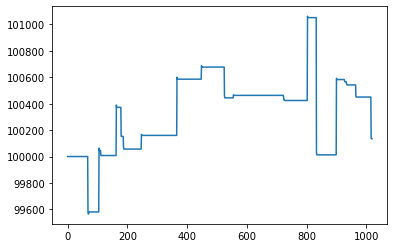

In [43]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all_a2c = backtest_stats(account_value=df_account_value_a2c)
perf_stats_all_a2c = pd.DataFrame(perf_stats_all_a2c)
perf_stats_all_a2c.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_a2c_"+now+'.csv')

M = df_account_value_a2c['account_value']
%matplotlib inline
plt.plot(M)
plt.show

In [44]:
perf_stats_all_a2c

,0
Annual return,0.000333
Cumulative returns,0.001348
Annual volatility,0.008236
Sharpe ratio,0.044572
Calmar ratio,0.032051
Stability,0.303936
Max drawdown,-0.010386
Omega ratio,1.056528
Sortino ratio,0.062359
Skew,NaN


==============Get Backtest Results===========
Annual return          0.0
Cumulative returns     0.0
Annual volatility      0.0
Sharpe ratio           NaN
Calmar ratio           NaN
Stability              0.0
Max drawdown           0.0
Omega ratio            NaN
Sortino ratio          NaN
Skew                   NaN
Kurtosis               NaN
Tail ratio             NaN
Daily value at risk    0.0
dtype: float64


/Users/chloewenqi/anaconda3/lib/python3.7/site-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/Users/chloewenqi/anaconda3/lib/python3.7/site-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/Users/chloewenqi/anaconda3/lib/python3.7/site-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


<function matplotlib.pyplot.show(close=None, block=None)>

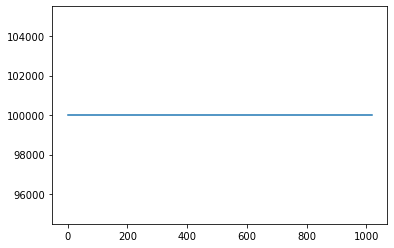

In [45]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all_td3 = backtest_stats(account_value=df_account_value_td3)
perf_stats_all_td3 = pd.DataFrame(perf_stats_all_td3)
perf_stats_all_td3.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_td3_"+now+'.csv')

M = df_account_value_td3['account_value']
%matplotlib inline
plt.plot(M)
plt.show

==============Get Backtest Results===========
Annual return         -0.000021
Cumulative returns    -0.000084
Annual volatility      0.006097
Sharpe ratio          -0.000356
Calmar ratio          -0.002853
Stability              0.476512
Max drawdown          -0.007264
Omega ratio            0.999410
Sortino ratio         -0.000506
Skew                        NaN
Kurtosis                    NaN
Tail ratio                  NaN
Daily value at risk   -0.000768
dtype: float64


/Users/chloewenqi/anaconda3/lib/python3.7/site-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


<function matplotlib.pyplot.show(close=None, block=None)>

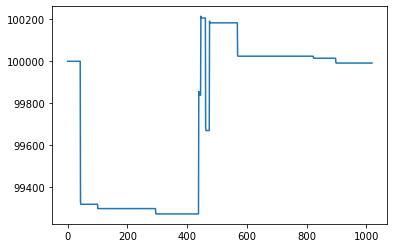

In [46]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all_ppo = backtest_stats(account_value=df_account_value_ppo)
perf_stats_all_ppo = pd.DataFrame(perf_stats_all_ppo)
perf_stats_all_ppo.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_ppo_"+now+'.csv')

M = df_account_value_ppo['account_value']
%matplotlib inline
plt.plot(M)
plt.show

==============Get Backtest Results===========
Annual return          0.000020
Cumulative returns     0.000081
Annual volatility      0.529885
Sharpe ratio           0.264521
Calmar ratio           0.000055
Stability              0.000014
Max drawdown          -0.364436
Omega ratio            1.042678
Sortino ratio          0.383884
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.042480
Daily value at risk   -0.066203
dtype: float64


<function matplotlib.pyplot.show(close=None, block=None)>

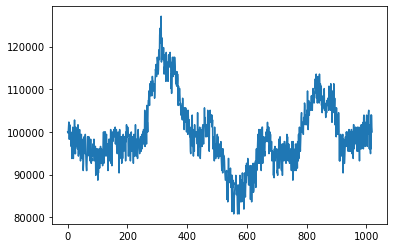

In [47]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all_ddpg = backtest_stats(account_value=df_account_value_ddpg)
perf_stats_all_ddpg = pd.DataFrame(perf_stats_all_ddpg)
perf_stats_all_ddpg.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_ddpg_"+now+'.csv')

M = df_account_value_ddpg['account_value']
%matplotlib inline
plt.plot(M)
plt.show

==============Get Backtest Results===========
Annual return          0.0
Cumulative returns     0.0
Annual volatility      0.0
Sharpe ratio           NaN
Calmar ratio           NaN
Stability              0.0
Max drawdown           0.0
Omega ratio            NaN
Sortino ratio          NaN
Skew                   NaN
Kurtosis               NaN
Tail ratio             NaN
Daily value at risk    0.0
dtype: float64


/Users/chloewenqi/anaconda3/lib/python3.7/site-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/Users/chloewenqi/anaconda3/lib/python3.7/site-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/Users/chloewenqi/anaconda3/lib/python3.7/site-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


<function matplotlib.pyplot.show(close=None, block=None)>

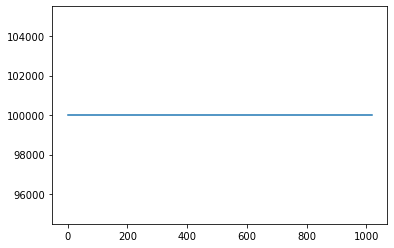

In [48]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all_sac = backtest_stats(account_value=df_account_value_sac)
perf_stats_all_sac = pd.DataFrame(perf_stats_all_sac)
perf_stats_all_sac.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_sac_"+now+'.csv')

M = df_account_value_sac['account_value']
%matplotlib inline
plt.plot(M)
plt.show

In [49]:
# print("==============Get Baseline Stats===========")
# baesline_perf_stats=get_baseline('Lloyds',start=1020,end=2040)

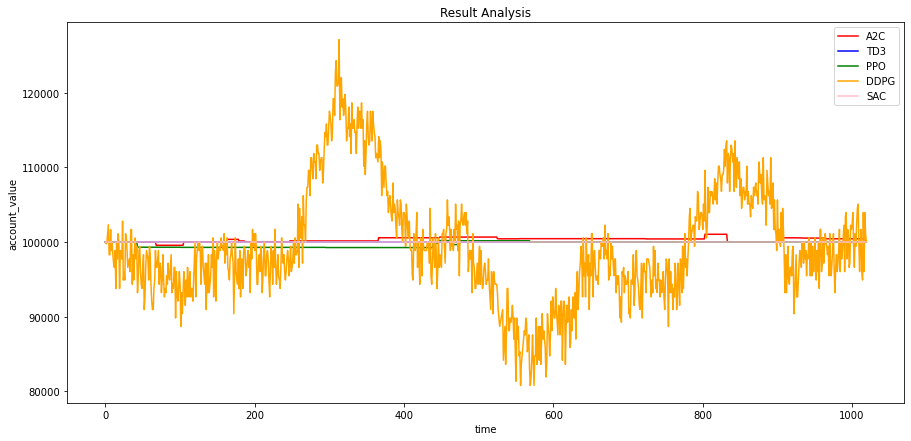

<Figure size 180000x84000 with 0 Axes>

In [57]:
#Plot the results
x = df_account_value_a2c['date']-1020
y_a2c = df_account_value_a2c['account_value']
y_td3 = df_account_value_td3['account_value']
y_ppo = df_account_value_ppo['account_value']
y_ddpg = df_account_value_ddpg['account_value']
y_sac = df_account_value_sac['account_value']

plt.title('Result Analysis')
plt.plot(x, y_a2c, color='red', label='A2C')
plt.plot(x,y_td3, color='blue', label='TD3')
plt.plot(x,y_ppo, color='green', label='PPO')
plt.plot(x,y_ddpg, color='orange', label='DDPG')
plt.plot(x,y_sac, color='pink', label='SAC')
plt.legend() # 显示图例

plt.xlabel('time')
plt.ylabel('account_value')
plt.figure(dpi=12000)
plt.rcParams['figure.figsize'] = (13.0, 7.0)
plt.show()

In [51]:
data=[['Begin Value',df_account_value_a2c['account_value'][0],df_account_value_td3['account_value'][0],df_account_value_ppo['account_value'][0],df_account_value_ddpg['account_value'][0],df_account_value_sac['account_value'][0]],
      ['End Value',df_account_value_a2c['account_value'][1019],df_account_value_td3['account_value'][1019],df_account_value_ppo['account_value'][1019],df_account_value_ddpg['account_value'][1019],df_account_value_sac['account_value'][1019]],
      ['Annual return',perf_stats_all_a2c.iat[0,0],perf_stats_all_td3.iat[0,0],perf_stats_all_ppo.iat[0,0],perf_stats_all_ddpg.iat[0,0],perf_stats_all_sac.iat[0,0]],
      ['total_timesteps',timesteps,timesteps,timesteps,timesteps,timesteps]
     ]
column_labels=["Item","A2C", "TD3", "PPO", 'DDPG', 'SAC']
df=pd.DataFrame(data,columns=column_labels)
sty=df.style
print(sty,type(sty))
sty

<pandas.io.formats.style.Styler object at 0x7febc5791350> <class 'pandas.io.formats.style.Styler'>


,Item,A2C,TD3,PPO,DDPG,SAC
0,Begin Value,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
1,End Value,100134.811000,100000.000000,99991.613000,100008.103000,100000.000000
2,Annual return,0.000333,0.000000,-0.000021,0.000020,0.000000
3,total_timesteps,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000


Here is the change of the Annual Reuren of A2C Model

<function matplotlib.pyplot.show(close=None, block=None)>

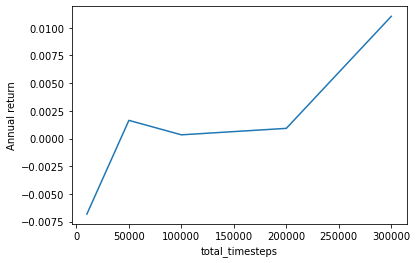

In [53]:
m = [-0.006820, 0.001640, 0.000333, 0.000917, 0.011037]
n = [10000, 50000, 100000, 200000, 300000]
%matplotlib inline
plt.plot(n,m)
plt.xlabel('total_timesteps')
plt.ylabel('Annual return')
plt.show